In [110]:
import numpy as np
import pandas as pd
from scipy import stats




import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

import matplotlib.pyplot as plt
import matplotlib as mpl



# 引入Kalman函数库
from pykalman import KalmanFilter

# 引入纯随机序列检测，只有是非纯随机序列，才能进行检测
from statsmodels.stats.diagnostic import acorr_ljungbox

# 引入时序分析模型进行模型匹配
from statsmodels.tsa.arima_model import ARMA

In [123]:
sec = '000300.XSHG'

end_date = '2019-4-30'
ncount = 50

Price_Series = get_price(sec, count =  ncount, end_date= end_date, frequency='30d', fields='close',fq = "none")['close']
Yield_ts = Price_Series/Price_Series.shift(1)
Yield_ts = Yield_ts.fillna(1)

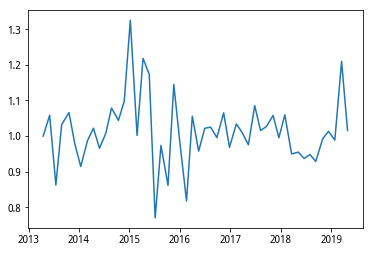

In [124]:
plt.plot(Yield_ts)

In [125]:
Yield_ts_log = np.log(Yield_ts)

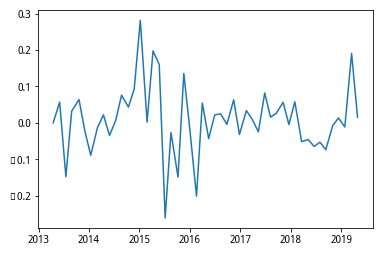

In [126]:
plt.plot(Yield_ts_log)

In [127]:
def rolling_statistics(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:

    fig, ax = plt.subplots(1, 1)
    # 共享x轴，生成次坐标轴
    ax_sub = ax.twinx()
    # 绘图
    l1, = ax.plot(timeseries.index, timeseries.values, 'b-', label='yield')
    l2, = ax.plot(rolmean.index, rolmean.values, 'r-', label='yield_mean')

    l3, = ax_sub.plot(rolstd.index, rolstd.values, 'y-', label='yield_std')

    plt.legend(handles=[l1, l2, l3], labels=['yield', 'yield_mean','yield_std'], loc=0)
    plt.title('Rolling Mean & Standard Deviation')

    plt.show(block=False)

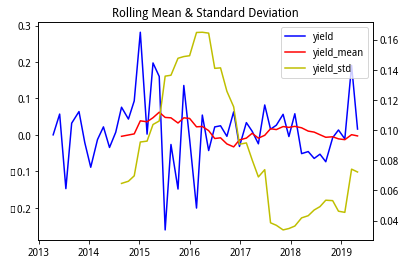

In [128]:
rolling_statistics(Yield_ts_log)

In [129]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    rolling_statistics(timeseries)#绘图
    print('Results of Augment Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

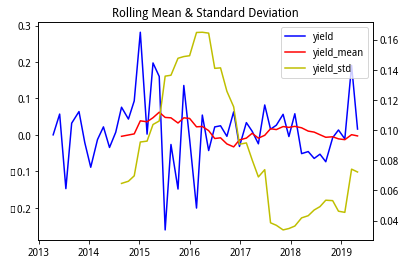

Results of Augment Dickey-Fuller Test:
Test Statistic                 -3.390027
p-value                         0.011304
#Lags Used                      5.000000
Number of Observations Used    44.000000
Critical Value (1%)            -3.588573
Critical Value (5%)            -2.929886
Critical Value (10%)           -2.603185
dtype: float64


In [130]:
adf_test(Yield_ts_log)

In [131]:
np.average(Yield_ts_log)

0.009296376076366838

In [132]:
def acf_pacf_plot(ts_log_diff):
    sm.graphics.tsa.plot_acf(ts_log_diff,lags=40) #ARIMA,q
    sm.graphics.tsa.plot_pacf(ts_log_diff,lags=40) #ARIMA,p


/opt/conda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


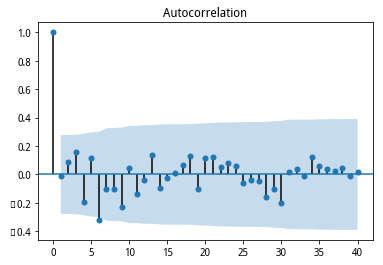

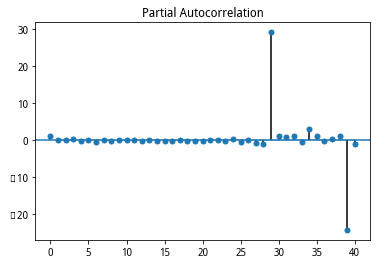

In [133]:
acf_pacf_plot(Yield_ts_log) 

In [134]:
#注意这里面使用的ts_log_diff是经过合适阶数的差分之后的数据，上文中提到ARIMA该开源库，不支持3阶以上的#差分。所以我们需要提前将数据差分好再传入
import sys
from statsmodels.tsa.arima_model import ARMA
def _proper_model(ts_log_diff, maxLag):
    best_p = 0 
    best_q = 0
    best_bic = sys.maxsize
    best_model=None
    for p in np.arange(maxLag):
        for q in np.arange(maxLag):
            model = ARMA(ts_log_diff, order=(p, q))
            try:
                results_ARMA = model.fit(disp=-1)
            except:
                continue
            bic = results_ARMA.bic
            print(bic, best_bic)
            if bic < best_bic:
                best_p = p
                best_q = q
                best_bic = bic
                best_model = results_ARMA
    return best_p,best_q,best_model
_proper_model(Yield_ts, 10) #对一阶差分求最优p和q

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

-86.32172648461078 9223372036854775807
-82.41378348384342 -86.32172648461078
-79.41134635590453 -86.32172648461078
-81.81601804021939 -86.32172648461078
-79.65530649993038 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-76.12536831373055 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-75.07799337639307 -86.32172648461078
-73.31032149850226 -86.32172648461078
-82.41459882023781 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

-79.0696574499539 -86.32172648461078
-75.48334346642109 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

-76.87187849566415 -86.32172648461078
-81.86829410926102 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-78.61168436385802 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

-75.66393507617876 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-78.44933226271039 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-78.35706700875701 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt

-75.47501744042127 -86.32172648461078
-72.00951780066967 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-74.5486153499271 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-75.77216835095562 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-67.1305733247982 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt

-63.23884536499463 -86.32172648461078
-74.69182807834741 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-72.26572220780623 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-73.43172777428916 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:674: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/opt/conda/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in add
  **kwargs)).imag/2./hess[i, j]
/opt/conda/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/opt/conda/lib/python3.6/site-packages/statsmo

nan -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-65.48974257585314 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt

-61.564139496699696 -86.32172648461078
-70.80056727219632 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-69.65573451740451 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-69.53362788959467 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-65.59284002509978 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-60.4591128394343 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/opt/conda/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


nan -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model

-54.965989807513154 -86.32172648461078
-68.72046459703509 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-66.88039863471465 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-65.69251233457081 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-59.12854013959642 -86.32172648461078
-50.971246864775935 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-49.955851734097486 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model

-46.27378887093657 -86.32172648461078
-64.849030666918 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-63.37742764592392 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-60.943536242215075 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-57.42865125674518 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-53.53398436322834 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-49.758697098498466 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-46.880474061454365 -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-42.124376069057746 -86.32172648461078
nan -86.32172648461078


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(0, 0, <statsmodels.tsa.arima_model.ARMAResultsWrapper at 0x7f93f18b3710>)

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS:0.4273')

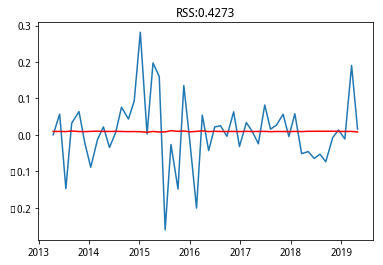

In [135]:
from statsmodels.tsa.arima_model import ARIMA


#RSS是残差平方和
# disp为-1代表不输出收敛过程的信息，True代表输出
model = ARMA(Yield_ts_log,order=(0,1,1)) #第二个参数代表使用了一阶差分
results_AR = model.fit(disp=-1)
plt.plot(Yield_ts_log)
plt.plot(results_AR.fittedvalues, color='red') #红色线代表预测值
plt.title('RSS:%.4f' % sum((results_AR.fittedvalues-Yield_ts_log)**2))#残差平方和
